In [1]:
%load_ext autoreload 
%autoreload 2 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

import tensorflow as tf 
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)

from utils import display, sample_batch

2023-07-21 05:56:24.521537: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-21 05:56:24.643648: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-21 05:56:24.679860: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-21 05:56:25.189641: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

1 Physical GPUs, 1 Logical GPUs


2023-07-21 05:56:25.828703: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-21 05:56:25.855907: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-21 05:56:25.856099: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-21 05:56:25.856766: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

### Parameters 

In [2]:
IMAGE_SIZE = 64
CHANNELS = 3
CLASSES = 2
BATCH_SIZE = 128
Z_DIM = 32
LEARNING_RATE = 0.00005
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
EPOCHS = 20
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9
LABEL = "Blond_Hair"

### Perepare the data

In [3]:
#load thee label dataset 
attributes = pd.read_csv("../data/celeba-dataset/list_attr_celeba.csv")
print(attributes.columns)
attributes.head()

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [4]:
#load the data 
labels = attributes[LABEL].tolist()
int_labels = [x if x==1 else 0 for x in labels]

In [5]:

train_data = utils.image_dataset_from_directory(
    "../data/celeba-dataset/img_align_celeba",
    labels=int_labels,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 202599 files belonging to 1 classes.


In [6]:
# Preprocess the data
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


train = train_data.map(
    lambda x, y: (preprocess(x), tf.one_hot(y, depth=CLASSES))
)

In [7]:
# Show some faces from the training set
train_sample = sample_batch(train)

In [8]:
random = train.take(1).get_single_element()

In [9]:
random[1][1]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 1.], dtype=float32)>

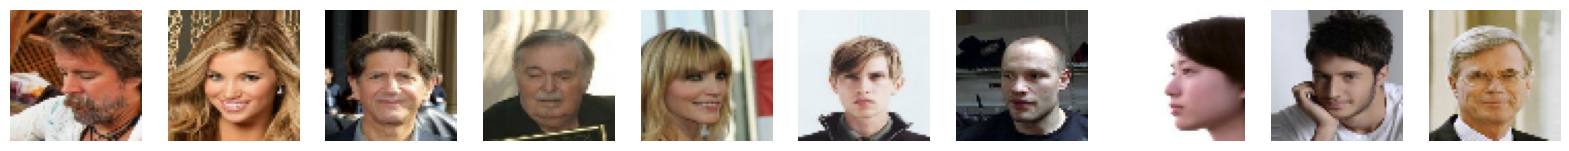

In [10]:
display(train_sample, cmap=None)

In [11]:
critic_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
label_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CLASSES))
x = layers.Concatenate(axis=-1)([critic_input, label_input])
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(1, kernel_size=4, strides=1, padding="valid")(x)
critic_output = layers.Flatten()(x)

critic = models.Model([critic_input, label_input], critic_output)
critic.summary()#Build the GAN

critic_input = layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS))
label_input = layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,CLASSES))
x = layers.Concatenate(axis=-1)([critic_input, label_input])



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 64, 64, 5)    0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   5184        ['concatenate[0][0]']        

In [12]:
generator_input = layers.Input(shape=(Z_DIM,))
label_input = layers.Input(shape=(CLASSES,))
x = layers.Concatenate(axis=-1)([generator_input, label_input])
x = layers.Reshape((1, 1, Z_DIM + CLASSES))(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=4, strides=2, padding="same", activation="tanh"
)(x)
generator = models.Model([generator_input, label_input], generator_output)
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 concatenate_2 (Concatenate)    (None, 34)           0           ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 1, 1, 34)     0           ['concatenate_2[0][0]']    

In [13]:
class ConditionalWGAN(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(ConditionalWGAN, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(ConditionalWGAN, self).compile(run_eagerly=True)
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [
            self.c_loss_metric,
            self.c_wass_loss_metric,
            self.c_gp_metric,
            self.g_loss_metric,
        ]

    def gradient_penalty(
        self, batch_size, real_images, fake_images, image_one_hot_labels
    ):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(
                [interpolated, image_one_hot_labels], training=True
            )

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        real_images, one_hot_labels = data

        image_one_hot_labels = one_hot_labels[:, None, None, :]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=IMAGE_SIZE, axis=1
        )
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=IMAGE_SIZE, axis=2
        )

        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )

            with tf.GradientTape() as tape:
                fake_images = self.generator(
                    [random_latent_vectors, one_hot_labels], training=True
                )

                fake_predictions = self.critic(
                    [fake_images, image_one_hot_labels], training=True
                )
                real_predictions = self.critic(
                    [real_images, image_one_hot_labels], training=True
                )

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(
                    real_predictions
                )
                c_gp = self.gradient_penalty(
                    batch_size, real_images, fake_images, image_one_hot_labels
                )
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(
                zip(c_gradient, self.critic.trainable_variables)
            )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        with tf.GradientTape() as tape:
            fake_images = self.generator(
                [random_latent_vectors, one_hot_labels], training=True
            )
            fake_predictions = self.critic(
                [fake_images, image_one_hot_labels], training=True
            )
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}

In [14]:
# Create a GAN
cgan = ConditionalWGAN(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [15]:
# Compile the GAN
cgan.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [16]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        # 0 label
        zero_label = np.repeat([[1, 0]], self.num_img, axis=0)
        generated_images = self.model.generator(
            [random_latent_vectors, zero_label]
        )
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="./output/generated_img_%03d_label_0.png" % (epoch),
            cmap=None,
        )

        # 1 label
        one_label = np.repeat([[0, 1]], self.num_img, axis=0)
        generated_images = self.model.generator(
            [random_latent_vectors, one_label]
        )
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="./output/generated_img_%03d_label_1.png" % (epoch),
            cmap=None,
        )

In [17]:
history = cgan.fit(
    train,
    epochs=EPOCHS * 100,
    steps_per_epoch=1,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)


Epoch 1/2000


2023-07-21 05:56:33.435497: E tensorflow/stream_executor/cuda/cuda_blas.cc:218] failed to create cublas handle: cublas error
2023-07-21 05:56:33.435529: E tensorflow/stream_executor/cuda/cuda_blas.cc:220] Failure to initialize cublas may be due to OOM (cublas needs some free memory when you initialize it, and your deep-learning framework may have preallocated more than its fair share), or may be because this binary was not built with support for the GPU in your machine.
2023-07-21 05:56:33.435552: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at conv_grad_input_ops.cc:185 : INTERNAL: Attempting to perform BLAS operation using StreamExecutor without BLAS support


InternalError: Exception encountered when calling layer "conv2d_transpose" "                 f"(type Conv2DTranspose).

{{function_node __wrapped__Conv2DBackpropInput_device_/job:localhost/replica:0/task:0/device:GPU:0}} Attempting to perform BLAS operation using StreamExecutor without BLAS support [Op:Conv2DBackpropInput]

Call arguments received by layer "conv2d_transpose" "                 f"(type Conv2DTranspose):
  • inputs=tf.Tensor(shape=(128, 1, 1, 34), dtype=float32)

In [ ]:
# Save the final models
generator.save("./models/generator")
critic.save("./models/critic")

In [ ]:
# 0 label
z_sample = np.random.normal(size=(10, Z_DIM))
class_label = np.repeat([[1, 0]], 10, axis=0)
imgs = cgan.generator.predict([z_sample, class_label])
display(imgs, cmap=None)

In [ ]:
# 1 label
z_sample = np.random.normal(size=(10, Z_DIM))
class_label = np.repeat([[0, 1]], 10, axis=0)
imgs = cgan.generator.predict([z_sample, class_label])
display(imgs, cmap=None)